In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt
import importlib
import seaborn as sns
import sys

import layers_v2 as layers
import util as util
import networks as networks
import distributions

torch.set_default_dtype(torch.float64)

In [2]:
sys.path.insert(0, '../exp/')
import util as util_data

In [3]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)
importlib.reload(distributions)

<module 'distributions' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/distributions.py'>

### Test LogitNormal

In [4]:
m = distributions.LogitNormal(torch.tensor([0.0]), torch.tensor([1.0]))
m.sample()

tensor([0.4725])

In [5]:
m1 = distributions.LogitNormal(torch.tensor([0.0]), torch.tensor([1.0]))
m2 = distributions.LogitNormal(torch.tensor([1.0]), torch.tensor([2.0]))

torch.distributions.kl_divergence(m1, m2)

tensor([0.4431])

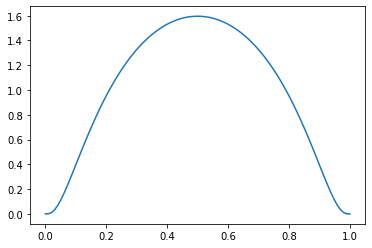

In [17]:
logit = lambda x: np.log(x/(1-x))

def logitnormal_pdf(x, mu=0, sig2=1):
    return 1/np.sqrt(2*np.pi*sig2)/(x*(1-x))*np.exp(-(logit(x)-mu)**2/(2*sig2))

eps = .0001
x = np.linspace(0+eps,1-eps,100)
plt.plot(x, logitnormal_pdf(x,0,1))

### Temp

In [20]:
a = nn.Parameter(torch.tensor(1.0))
b = a
a.data = torch.tensor(2.0)
b

Parameter containing:
tensor(2., requires_grad=True)

In [25]:
a = nn.Parameter(torch.tensor(1.0))
m = torch.distributions.normal.Normal(a, torch.tensor(3.0))
a.data = torch.tensor(2.0)
m.loc

Parameter containing:
tensor(2., requires_grad=True)

In [37]:
a = nn.Parameter(torch.tensor(-1.0))
t = torch.distributions.transforms.AbsTransform()
b = t(a)
a.data = torch.tensor(-2.0)
b

tensor(1., grad_fn=<AbsBackward>)

In [46]:
a = nn.Parameter(torch.tensor(-1.0))
t = torch.nn.Softplus()
b = t(a)
print(b)
a.data = torch.tensor(-2.0)
print(b)
print(t(a))

tensor(0.3133, grad_fn=<SoftplusBackward>)
tensor(0.3133, grad_fn=<SoftplusBackward>)
tensor(0.1269, grad_fn=<SoftplusBackward>)


In [29]:
b

tensor(1., grad_fn=<AbsBackward>)

In [57]:
loc = nn.Parameter(torch.tensor(0.0))
scale = nn.Parameter(torch.tensor(1.0))

loss = (1.0 - (loc + torch.randn(1)*scale))**2
loss.backward()
loc.grad

tensor(-2.4578)

In [59]:
loc = nn.Parameter(torch.tensor(0.0))
scale = nn.Parameter(torch.tensor(1.0))

m = torch.distributions.normal.Normal(loc,scale)

loss = (1.0 - m.rsample())**2
loss.backward()
loc.grad

tensor(-3.9945)

In [71]:
m = torch.distributions.normal.Normal(torch.tensor(0.0),torch.tensor(-100.0))
m.sample()

tensor(-17.6694)

In [88]:
torch.normal(torch.tensor(0.), torch.tensor(-1000.))

tensor(1120.5515)

In [90]:
torch.distributions.normal.Normal.arg_constraints['scale']

GreaterThan(lower_bound=0.0)

In [97]:
transform_to = torch.distributions.constraint_registry.ConstraintRegistry()

@transform_to.register(torch.distributions.constraints.positive)
def _transform_to_positive(constraint):
    return torch.distributions.transforms.ExpTransform()

In [99]:
constraint = torch.distributions.normal.Normal.arg_constraints['scale']
scale = transform_to(constraint)(torch.zeros(1))  # constrained
u = transform_to(constraint).inv(scale)

In [106]:
a = nn.Parameter(torch.tensor(-1.0))
scale = transform_to(constraint)(a)  # constrained
print(a)
print(torch.log(scale))
a.data = torch.tensor(-2.0)
print(a)
print(torch.log(scale))

Parameter containing:
tensor(-1., requires_grad=True)
tensor(-1., grad_fn=<LogBackward>)
Parameter containing:
tensor(-2., requires_grad=True)
tensor(-1., grad_fn=<LogBackward>)


In [ ]:
a = nn.Parameter(torch.tensor(-1.0))
t = torch.distributions.transforms.AbsTransform()
b = t(a)
a.data = torch.tensor(-2.0)
b

### SIN dataset

In [4]:
n_obs = 100
dim_in = 2
Z, X, Y, sig2 = util_data.load_data('sin', n_obs=n_obs, dim_in=dim_in, sig2=.01, seed=0)


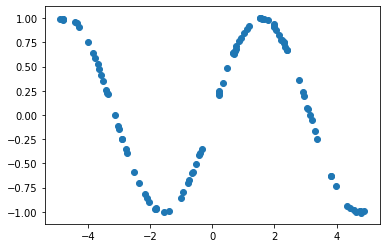

In [5]:
plt.scatter(Z[:,0],Y)

In [18]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)
importlib.reload(distributions)

<module 'distributions' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/distributions.py'>

In [19]:
# logitnormal
torch.manual_seed(2)
model = networks.RffHs(dim_in, 1, dim_hidden=50, sig2_inv=1/sig2, \
                       layer_in_name='RffVarSelectLogitNormalLayer',\
                       s_loc_prior=0.5,
                       s_scale_prior=1.0)


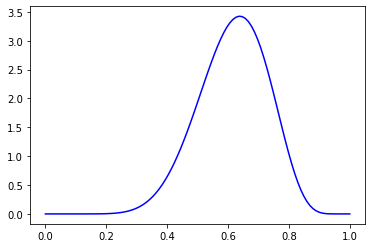

In [8]:
eps = .0001
x = np.linspace(0+eps,1-eps,100)

logit = lambda x: np.log(x/(1-x))

def logitnormal_pdf(x, mu=0, sig2=1):
    return 1/np.sqrt(2*np.pi*sig2)/(x*(1-x))*np.exp(-(logit(x)-mu)**2/(2*sig2))


loc = model.layer_in.s_loc_prior.item()
scale = model.layer_in.s_loc_prior.item()
plt.plot(x, logitnormal_pdf(x,loc,scale**2), color='blue',label='s0')

In [22]:
# beta
torch.manual_seed(2)
model = networks.RffHs(dim_in, 1, dim_hidden=50, sig2_inv=1/sig2, \
                       layer_in_name='RffVarSelectBetaLayer',\
                       s_a_prior=3,
                       s_b_prior=2)

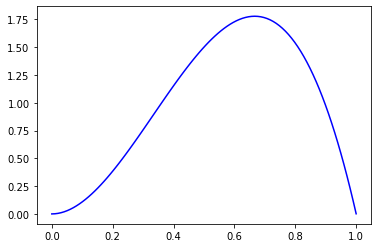

In [23]:
eps = .0001
x = np.linspace(0+eps,1-eps,100)
import scipy

a = model.layer_in.s_a_prior.item()
b = model.layer_in.s_b_prior.item()
plt.plot(x, scipy.stats.beta.pdf(x,a,b), color='blue',label='s0')


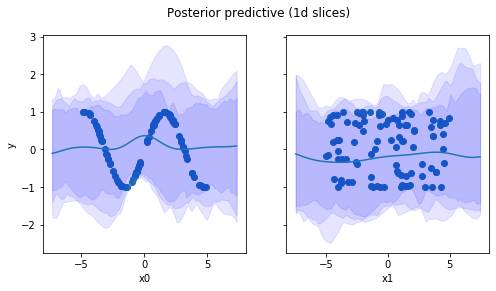

In [20]:
def sample_f_prior(x):
    with torch.no_grad():
        return model.forward(torch.from_numpy(x), weights_type_layer_in='sample_prior', weights_type_layer_out='sample_prior')

fig, ax = util.plot_slices(sample_f_prior, Z, Y, quantile=.5, n_samp=50, figsize=(4*2,4))


In [23]:
torch.manual_seed(2)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
#optimizer = torch.optim.Adam(model.parameters(), lr=.0001)
model.reinit_parameters(torch.from_numpy(Z),torch.from_numpy(Y),n_reinit=10) 


In [24]:
for name, p in model.named_parameters():
    print(name, p.detach())

layer_in.s_loc tensor([-0.0066,  0.0219])
layer_in.s_scale_untrans tensor([ 0.0170, -0.0132])


In [277]:
q = model.layer_in.get_variational()

In [286]:
q.sample((3,)).shape

torch.Size([3, 2])

In [285]:
q.sample().shape

torch.Size([2])

In [296]:
D = 2 # dimension of input
K = 3 # number of hidden units
N = 4 # number of observations
S = 1 # number of samples from q

s = torch.ones((S,D))
w = torch.ones((K,D))
x = torch.ones((N,D))

xs = x.unsqueeze(1) * s.unsqueeze(0)

torch.squeeze(F.linear(xs,w)).shape

torch.Size([4, 3])

In [289]:
x.unsqueeze(1).shape

torch.Size([4, 1, 2])

In [294]:
s.unsqueeze(0).shape

torch.Size([1, 5, 2])

In [79]:
s.view(1,1,-1).

torch.Size([1, 1, 2])

In [76]:
x.shape

torch.Size([3, 1])

In [84]:
x = torch.tensor([[1], [2], [3]])

x.expand(-1, 4)

tensor([[1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3]])

In [77]:
x.expand(3, 4).shape

torch.Size([3, 4])

In [72]:
x = torch.tensor([[1,2,3]])
x.expand(3,1)

RuntimeError: The expanded size of the tensor (1) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [3, 1].  Tensor sizes: [1, 3]

In [297]:
# dimensions of m are observations
N = 5 # number of observations
S = 2 # number of samples from q
D = 1 # output dimension

loc = torch.randn((N,S,D)) # network output
scale = torch.tensor(1.0)

m = torch.distributions.normal.Normal(loc, scale)
[m.batch_shape, m.event_shape]

[torch.Size([5, 2, 1]), torch.Size([])]

In [308]:
data = torch.ones((N,D))
m.log_prob(data.unsqueeze(1)).shape

torch.Size([5, 2, 1])

In [309]:
m.log_prob(data.unsqueeze(1))

tensor([[[-0.9855],
         [-2.0768]],

        [[-2.0024],
         [-0.9379]],

        [[-4.9539],
         [-1.4323]],

        [[-1.2106],
         [-3.7649]],

        [[-4.0840],
         [-1.4917]]])

In [303]:
m.log_prob(data.unsqueeze(1)).mean(1).sum(0)

tensor([-11.4700])

In [301]:
diagm = torch.distributions.independent.Independent(m,1)
[diagm.batch_shape, diagm.event_shape]

[torch.Size([5, 2]), torch.Size([1])]

In [270]:
data = torch.ones((N,S,D))
diagm.log_prob(data)

tensor([-3.5973, -5.4053, -3.3917, -3.4972, -4.3453])

In [224]:
# dimensions of m are observations
loc = torch.tensor([0.,0.])
scale = torch.tensor(1.0)

m = torch.distributions.normal.Normal(loc.view(-1), scale)
[m.batch_shape, m.event_shape]

[torch.Size([2]), torch.Size([])]

In [233]:
S = 5
y=torch.randn(S, 2) 
y

tensor([[ 0.1994, -1.3322],
        [ 0.3696, -0.4417],
        [ 1.0378,  0.1359],
        [ 0.0681, -1.8377],
        [-0.8369, -0.9166]])

In [234]:
m.log_prob(y)

tensor([[-0.9388, -1.8063],
        [-0.9872, -1.0165],
        [-1.4574, -0.9282],
        [-0.9213, -2.6076],
        [-1.2691, -1.3390]])

In [168]:
m.log_prob(y)

tensor([[-0.9634],
        [-0.9775]])

In [229]:
m.log_prob(y).mean(0).sum()

tensor(-2.1879)

In [152]:
y=torch.randn(2) # first dimension could be anything (like samples), second dimension is observations
y

tensor([0.4247, 0.7341])

In [154]:
m.log_prob(y.reshape(-1,1))

tensor([[-1.0091, -1.0091],
        [-1.1884, -1.1884]])

In [156]:
y.reshape(-1,1).shape

torch.Size([2, 1])

Epoch[1/1000], kl: 0.411124, likelihood: -1533.575307, elbo: -892.885010
Epoch[2/1000], kl: 0.463256, likelihood: -688.204737, elbo: -4590.804522
Epoch[3/1000], kl: 0.419382, likelihood: -4325.772574, elbo: 32.587838
Epoch[4/1000], kl: 0.447998, likelihood: -1358.615620, elbo: -1982.147208
Epoch[5/1000], kl: 0.534871, likelihood: -5440.061592, elbo: -111.171877
Epoch[6/1000], kl: 0.623009, likelihood: -1251.208580, elbo: -565.518507
Epoch[7/1000], kl: 0.751473, likelihood: -891.227206, elbo: -232.637248
Epoch[8/1000], kl: 0.780025, likelihood: -598.157002, elbo: -1364.944319
Epoch[9/1000], kl: 0.941661, likelihood: -1172.352714, elbo: -560.571572
Epoch[10/1000], kl: 1.025569, likelihood: -110.932811, elbo: -1233.337491
Epoch[11/1000], kl: 1.033145, likelihood: -1213.607908, elbo: -713.418990
Epoch[12/1000], kl: 1.082279, likelihood: -2973.837162, elbo: -21.843560
Epoch[13/1000], kl: 1.112832, likelihood: -1263.643849, elbo: -1079.222615
Epoch[14/1000], kl: 1.157673, likelihood: -833.64

Epoch[117/1000], kl: 9.211285, likelihood: 131.879325, elbo: 98.072468
Epoch[118/1000], kl: 9.542293, likelihood: 106.728955, elbo: 124.005362
Epoch[119/1000], kl: 9.585130, likelihood: 105.992535, elbo: 119.723182
Epoch[120/1000], kl: 9.713647, likelihood: 135.588621, elbo: 126.672844
Epoch[121/1000], kl: 9.741423, likelihood: 126.135325, elbo: 103.989681
Epoch[122/1000], kl: 9.756139, likelihood: 132.035808, elbo: 122.509175
Epoch[123/1000], kl: 9.845222, likelihood: 126.779217, elbo: 112.164309
Epoch[124/1000], kl: 9.932267, likelihood: 135.735248, elbo: 115.251006
Epoch[125/1000], kl: 9.932162, likelihood: 115.289537, elbo: 99.200414
Epoch[126/1000], kl: 9.984738, likelihood: 108.032048, elbo: 33.400278
Epoch[127/1000], kl: 10.169249, likelihood: 126.558885, elbo: 118.394142
Epoch[128/1000], kl: 10.389486, likelihood: 125.010973, elbo: 111.975178
Epoch[129/1000], kl: 10.572184, likelihood: 135.727673, elbo: 126.216966
Epoch[130/1000], kl: 10.581389, likelihood: 98.988680, elbo: 95.

Epoch[230/1000], kl: 18.829077, likelihood: 134.882600, elbo: 116.364881
Epoch[231/1000], kl: 18.732156, likelihood: 133.584974, elbo: 110.396399
Epoch[232/1000], kl: 18.589659, likelihood: 132.316766, elbo: 110.022535
Epoch[233/1000], kl: 18.791639, likelihood: 133.756180, elbo: 113.908337
Epoch[234/1000], kl: 18.633451, likelihood: 133.310257, elbo: 114.618496
Epoch[235/1000], kl: 18.464760, likelihood: 132.878803, elbo: 115.443879
Epoch[236/1000], kl: 18.537396, likelihood: 133.073587, elbo: 115.601130
Epoch[237/1000], kl: 18.536206, likelihood: 131.950538, elbo: 112.479285
Epoch[238/1000], kl: 18.442918, likelihood: 134.272496, elbo: 115.333797
Epoch[239/1000], kl: 17.944447, likelihood: 135.663275, elbo: 114.751009
Epoch[240/1000], kl: 17.713533, likelihood: 135.797531, elbo: 117.768698
Epoch[241/1000], kl: 17.446824, likelihood: 133.671068, elbo: 117.192027
Epoch[242/1000], kl: 17.358844, likelihood: 130.104300, elbo: 113.117786
Epoch[243/1000], kl: 17.351612, likelihood: 133.007

Epoch[344/1000], kl: 16.544615, likelihood: 136.072529, elbo: 116.623950
Epoch[345/1000], kl: 16.141535, likelihood: 131.211260, elbo: 116.276344
Epoch[346/1000], kl: 15.983902, likelihood: 132.123245, elbo: 113.962158
Epoch[347/1000], kl: 16.437423, likelihood: 131.592995, elbo: 114.249227
Epoch[348/1000], kl: 16.493198, likelihood: 134.037924, elbo: 117.791316
Epoch[349/1000], kl: 16.416993, likelihood: 131.252699, elbo: 118.188407
Epoch[350/1000], kl: 16.528534, likelihood: 132.722192, elbo: 115.521526
Epoch[351/1000], kl: 16.303448, likelihood: 135.661100, elbo: 119.439747
Epoch[352/1000], kl: 16.452106, likelihood: 134.023724, elbo: 116.656281
Epoch[353/1000], kl: 16.107496, likelihood: 134.182807, elbo: 118.508880
Epoch[354/1000], kl: 15.623321, likelihood: 127.311937, elbo: 110.251088
Epoch[355/1000], kl: 15.429881, likelihood: 134.654470, elbo: 119.822032
Epoch[356/1000], kl: 15.451298, likelihood: 135.350951, elbo: 119.972788
Epoch[357/1000], kl: 15.056227, likelihood: 130.384

Epoch[457/1000], kl: 14.803385, likelihood: 129.931095, elbo: 104.372652
Epoch[458/1000], kl: 15.252331, likelihood: 132.391481, elbo: 117.637702
Epoch[459/1000], kl: 15.063635, likelihood: 127.864646, elbo: 116.240135
Epoch[460/1000], kl: 15.099874, likelihood: 134.337682, elbo: 119.468846
Epoch[461/1000], kl: 14.758695, likelihood: 132.017147, elbo: 117.099600
Epoch[462/1000], kl: 14.700497, likelihood: 126.328163, elbo: 113.740951
Epoch[463/1000], kl: 14.422421, likelihood: 135.518438, elbo: 120.013162
Epoch[464/1000], kl: 14.145702, likelihood: 132.423043, elbo: 117.975579
Epoch[465/1000], kl: 14.217004, likelihood: 133.611817, elbo: 119.301062
Epoch[466/1000], kl: 14.057524, likelihood: 130.248380, elbo: 117.243815
Epoch[467/1000], kl: 13.638392, likelihood: 132.261245, elbo: 118.618425
Epoch[468/1000], kl: 13.479536, likelihood: 133.970355, elbo: 119.374239
Epoch[469/1000], kl: 13.346002, likelihood: 132.724846, elbo: 117.894189
Epoch[470/1000], kl: 13.279017, likelihood: 130.851

Epoch[570/1000], kl: 13.672709, likelihood: 133.474995, elbo: 120.374264
Epoch[571/1000], kl: 13.419726, likelihood: 131.171099, elbo: 117.805373
Epoch[572/1000], kl: 13.410545, likelihood: 133.910837, elbo: 121.475899
Epoch[573/1000], kl: 13.590700, likelihood: 126.796178, elbo: 109.689502
Epoch[574/1000], kl: 13.826292, likelihood: 132.936917, elbo: 116.348629
Epoch[575/1000], kl: 13.474252, likelihood: 131.863229, elbo: 117.734446
Epoch[576/1000], kl: 13.227249, likelihood: 132.218949, elbo: 118.500817
Epoch[577/1000], kl: 12.979466, likelihood: 134.251584, elbo: 120.929965
Epoch[578/1000], kl: 12.885945, likelihood: 132.159630, elbo: 118.138004
Epoch[579/1000], kl: 12.705079, likelihood: 126.852105, elbo: 116.075531
Epoch[580/1000], kl: 12.773840, likelihood: 132.762398, elbo: 120.156528
Epoch[581/1000], kl: 13.038033, likelihood: 131.921808, elbo: 115.155254
Epoch[582/1000], kl: 13.166150, likelihood: 135.199378, elbo: 121.685531
Epoch[583/1000], kl: 12.995350, likelihood: 130.561

Epoch[683/1000], kl: 12.847703, likelihood: 134.616597, elbo: 120.817508
Epoch[684/1000], kl: 12.548468, likelihood: 135.651556, elbo: 122.374914
Epoch[685/1000], kl: 12.378813, likelihood: 133.898322, elbo: 121.799109
Epoch[686/1000], kl: 12.148836, likelihood: 134.253817, elbo: 121.958630
Epoch[687/1000], kl: 11.990640, likelihood: 134.458914, elbo: 124.074200
Epoch[688/1000], kl: 11.975775, likelihood: 131.725003, elbo: 122.028793
Epoch[689/1000], kl: 12.075431, likelihood: 130.925141, elbo: 119.741107
Epoch[690/1000], kl: 12.430382, likelihood: 132.641401, elbo: 116.987570
Epoch[691/1000], kl: 12.354621, likelihood: 131.896213, elbo: 119.179411
Epoch[692/1000], kl: 12.387296, likelihood: 127.435087, elbo: 108.295812
Epoch[693/1000], kl: 12.704077, likelihood: 131.543985, elbo: 120.072793
Epoch[694/1000], kl: 12.585473, likelihood: 130.803523, elbo: 119.814601
Epoch[695/1000], kl: 12.585173, likelihood: 132.168116, elbo: 117.288618
Epoch[696/1000], kl: 12.499570, likelihood: 131.817

Epoch[796/1000], kl: 14.117784, likelihood: 123.595140, elbo: 106.919020
Epoch[797/1000], kl: 14.195788, likelihood: 129.467952, elbo: 108.721734
Epoch[798/1000], kl: 14.203892, likelihood: 133.720388, elbo: 117.878859
Epoch[799/1000], kl: 14.048004, likelihood: 133.649300, elbo: 117.960168
Epoch[800/1000], kl: 13.723439, likelihood: 131.272450, elbo: 118.793782
Epoch[801/1000], kl: 13.973322, likelihood: 130.719694, elbo: 117.193006
Epoch[802/1000], kl: 13.822598, likelihood: 125.574099, elbo: 114.513225
Epoch[803/1000], kl: 13.543924, likelihood: 132.144621, elbo: 119.526764
Epoch[804/1000], kl: 13.553228, likelihood: 129.810275, elbo: 114.376891
Epoch[805/1000], kl: 13.291042, likelihood: 131.687952, elbo: 113.083286
Epoch[806/1000], kl: 12.964217, likelihood: 130.276777, elbo: 114.776209
Epoch[807/1000], kl: 13.370225, likelihood: 134.149473, elbo: 112.006016
Epoch[808/1000], kl: 13.738374, likelihood: 122.159872, elbo: 103.641216
Epoch[809/1000], kl: 13.740020, likelihood: 130.278

Epoch[910/1000], kl: 13.472506, likelihood: 131.087641, elbo: 120.939670
Epoch[911/1000], kl: 13.396353, likelihood: 132.205298, elbo: 118.015090
Epoch[912/1000], kl: 13.389279, likelihood: 132.074721, elbo: 115.358779
Epoch[913/1000], kl: 13.108401, likelihood: 128.793874, elbo: 112.729489
Epoch[914/1000], kl: 13.285498, likelihood: 131.276494, elbo: 114.158636
Epoch[915/1000], kl: 13.062097, likelihood: 132.973321, elbo: 119.743484
Epoch[916/1000], kl: 12.862980, likelihood: 131.450218, elbo: 117.042785
Epoch[917/1000], kl: 12.527600, likelihood: 132.984337, elbo: 117.858307
Epoch[918/1000], kl: 12.415135, likelihood: 129.977883, elbo: 119.257673
Epoch[919/1000], kl: 12.300573, likelihood: 129.723487, elbo: 113.621527
Epoch[920/1000], kl: 12.257731, likelihood: 132.560543, elbo: 119.979272
Epoch[921/1000], kl: 12.308655, likelihood: 132.460989, elbo: 120.936319
Epoch[922/1000], kl: 12.250926, likelihood: 128.699783, elbo: 118.564629
Epoch[923/1000], kl: 12.470253, likelihood: 109.099

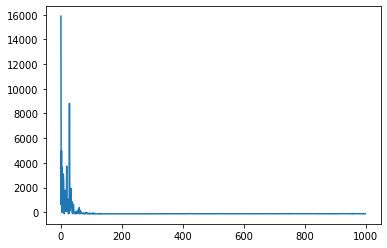

In [25]:
elbo = -networks.train(model, optimizer, torch.from_numpy(Z), torch.from_numpy(Y), n_epochs=1000, n_rep_opt=100, print_freq=1)
plt.plot(-elbo)

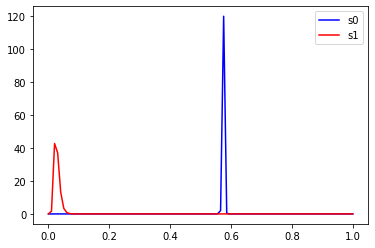

In [26]:
# logitnormal
eps = .0001
x = np.linspace(0+eps,1-eps,100)

logit = lambda x: np.log(x/(1-x))

def logitnormal_pdf(x, mu=0, sig2=1):
    return 1/np.sqrt(2*np.pi*sig2)/(x*(1-x))*np.exp(-(logit(x)-mu)**2/(2*sig2))


loc = model.layer_in.s_loc[0].detach().numpy()
scale = model.layer_in.transform(model.layer_in.s_scale_untrans[0]).detach().numpy()
plt.plot(x, logitnormal_pdf(x,loc,scale**2), color='blue',label='s0')

loc = model.layer_in.s_loc[1].detach().numpy()
scale = model.layer_in.transform(model.layer_in.s_scale_untrans[1]).detach().numpy()
plt.plot(x, logitnormal_pdf(x,loc,scale**2), color='red',label='s1')
plt.legend()


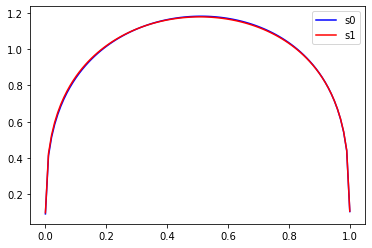

In [307]:
# beta
eps = .0001
x = np.linspace(0+eps,1-eps,100)
import scipy

a = model.layer_in.untransform(model.layer_in.s_a_trans[0]).detach().numpy()
b = model.layer_in.untransform(model.layer_in.s_b_trans[0]).detach().numpy()
plt.plot(x, scipy.stats.beta.pdf(x,a,b), color='blue',label='s0')

a = model.layer_in.untransform(model.layer_in.s_a_trans[1]).detach().numpy()
b = model.layer_in.untransform(model.layer_in.s_b_trans[1]).detach().numpy()
plt.plot(x, scipy.stats.beta.pdf(x,a,b), color='red',label='s1')

plt.legend()


In [28]:
def sample_f_post(x_test, x_train=torch.from_numpy(Z), y_train=torch.from_numpy(Y)):
    # inputs and outputs are numpy arrays
    #return model(torch.from_numpy(x), weights_type_layer_in='sample_post', weights_type_layer_out='sample_post').detach().numpy()

    # sample from variational dist then sample weights (conjugate)
    #model.fixed_point_updates(torch.from_numpy(Z),torch.from_numpy(Y)) 
    
    #return model(torch.from_numpy(x), weights_type_layer_in='stored', weights_type_layer_out='stored').detach().numpy()

    with torch.no_grad():
        return model.sample_posterior_predictive(x_test=torch.from_numpy(x_test), x_train=x_train, y_train=y_train).numpy().reshape(-1)


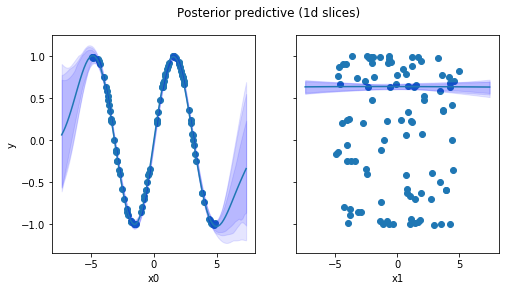

In [29]:
fig, ax = util.plot_slices(sample_f_post, Z, Y, quantile=.5, n_samp=50, figsize=(4*2,4))


#### GPy for comparison

In [29]:
import GPy
kernel = GPy.kern.RBF(input_dim=2, variance=1., lengthscale=1.)

In [30]:
m = GPy.models.GPRegression(Z,Y,kernel)

m.Gaussian_noise.variance = sig2
m.Gaussian_noise.fix()
m.optimize_restarts(num_restarts = 10, verbose=False)

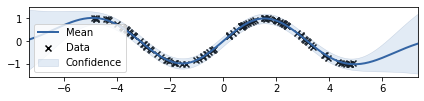

In [41]:
slices = [0]
figure = GPy.plotting.plotting_library().figure(3, 1)
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(1,y)], row=(i+1), plot_data=True)
#GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing')

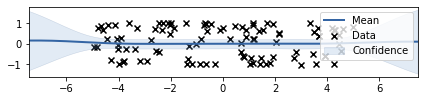

In [42]:
slices = [0]
figure = GPy.plotting.plotting_library().figure(3, 1)
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(0,y)], row=(i+1), plot_data=True)
#GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing_vertical')